Authors: Hadi Salman, Elif Ayvali, and Yifei Ma

Please acknowledge:
GPML toolkit by Carl Edward Rasmussen and Hannes Nickisch
GPML_EXTENSIONS by Roman Garnett

Please cite:
Active Area Search paper by Yifei Ma et al
Active Level Sets Alkis Gotovos et al

In [1]:
addpath(genpath(strcat(pwd, '/code/discrete_probing')))

In [2]:
% true model
clc;close all;clear
load 2tumors_experiment.mat
%load 1tumor_1artery.mat

In [3]:
x1 = reshape(x_gnd(:,1), [51,51])';
x2 = reshape(x_gnd(:,2), [51,51])';
x3 = reshape(x_gnd(:,3), [51,51])';
y = reshape(y_gnd, [51,51])';
x_gnd = [x1(:), x2(:), x3(:)];
y_gnd = y(:);%/max(y(:));

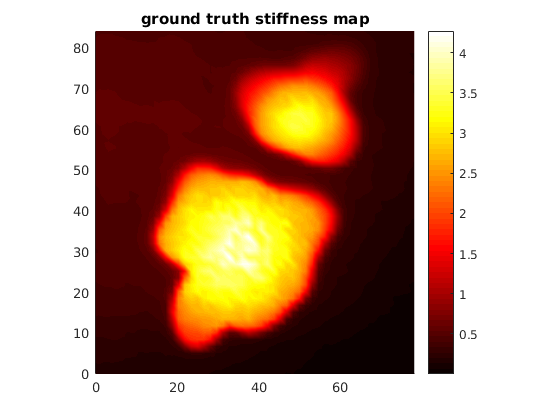

In [4]:
surface(x1,x2,x3,y)
colormap hot
title('ground truth stiffness map')
shading interp
axis equal tight
colorbar

In [5]:
L1 = x1(1,end) - x1(1,1);
L2 = x2(end,1) - x2(1,1);
[region_grid_x, region_grid_y] = meshgrid(linspace(0,L1,11), linspace(0,L2,11));
region_grid_x = region_grid_x(:,1:end-1);
region_grid_y = region_grid_y(1:end-1,:);
regions = [region_grid_x(:), region_grid_x(:)+L1/11, region_grid_y(:), region_grid_y(:)+L2/11];

In [6]:
x_gnd=x_gnd(:,1:2);
gp_model = struct('inf',@infExact, 'mean', @meanZero, 'cov', @covSEiso, 'lik', @likGauss);
sn = 0.01; ell =6; sf = sqrt(1);Ncg=30;
gp_para.lik = log(sn); gp_para.cov = log([ell; sf]);
%%
x_shape  = [51,51];%how to select this?
side     = 1;
beta_t   = 9;
eps_band = 0.1;
level    = 1;

In [7]:
gnd = ActiveAreaSearch(gp_model, gp_para, x_gnd, regions, level, side, highprob);
found = gnd.update(x_gnd, y_gnd);

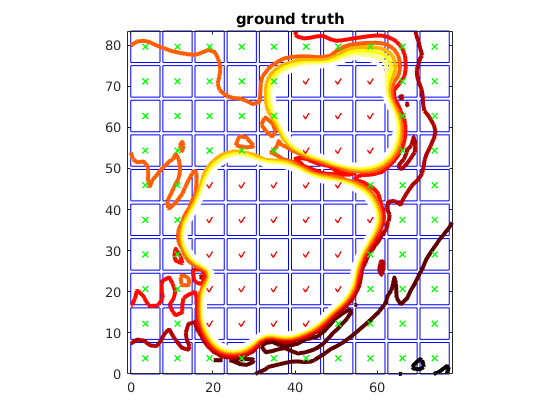

In [8]:
figure; clf;
[~, ~, f, fs2] = gnd.predict_points(x_gnd);
plot_demo(x_shape, x_gnd, f, fs2, [], regions, level, gnd.alpha, gnd.beta2, found, 'plotTailGaussian', false);
% color_line3(x_gnd(:,1),x_gnd(:,2),ones(length(x_gnd(:,2)),1),y_gnd,'.')
set(gcf, 'Position', [000, 100, 280, 280]);axis equal;
axis equal
title('ground truth');
drawnow;

In [9]:
num_runs = 1;
queryLen = 30;

In [10]:
recall_aas = nan(num_runs, queryLen);
recall_lse = nan(num_runs, queryLen);
recall_ei  = nan(num_runs, queryLen);
recall_unc = nan(num_runs, queryLen);
recall_rnd = nan(num_runs, queryLen);

## aas

In [11]:
aas = ActiveAreaSearch(gp_model, gp_para, x_gnd, regions, level, side, highprob);

In [12]:
for query_count = 0:queryLen-1
    u = aas.utility();
    [~, ind] = max_tiebreak(u);
    if query_count==0 %save the initial point so that all algorithms start from same point
        ind = 885;
        ind_start=ind;
    end
    found = aas.update(x_gnd(ind, :), y_gnd(ind, :));
end

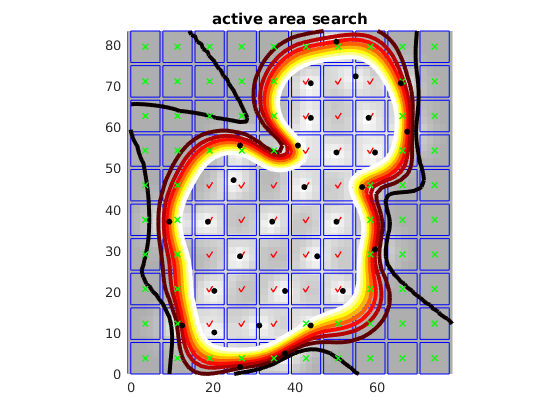

In [13]:
figure; clf;hold on;
[~, ~, f, fs2] = aas.predict_points(x_gnd);
plot_demo(x_shape, x_gnd, f, fs2, aas.collected_locs, regions, level, aas.alpha, aas.beta2, found, 'plotTailGaussian', false);
set(gcf, 'Position', [300, 100, 280, 280]); axis equal;
title('active area search');
drawnow;

## lse

In [14]:
lse = ActiveLevelSetEstimation(gp_model, gp_para, x_gnd, level, beta_t, eps_band);

In [15]:
for query_count = 0:queryLen-1
    u = lse.utility();
    if query_count==0 %for all algorithms to start from same point
        ind = ind_start;
    else
        [~, ind] = max_tiebreak(u);
    end
        
    lse.update(x_gnd(ind, :), y_gnd(ind, :));
end

In [16]:
region_measure_lse = ActiveAreaSearch(gp_model, gp_para, x_gnd, regions, level, side, highprob);
found = region_measure_lse.update(lse.collected_locs, lse.collected_vals);

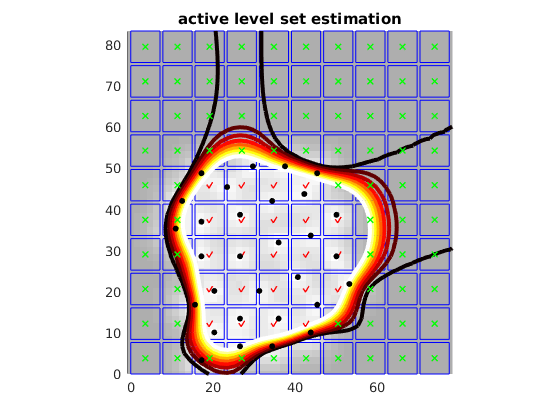

In [17]:
figure; clf;hold on;
[~, ~, f, fs2] = region_measure_lse.predict_points(x_gnd);
plot_demo(x_shape, x_gnd, f, fs2, lse.collected_locs, regions, level, region_measure_lse.alpha, region_measure_lse.beta2, found, 'plotTailGaussian', false);
set(gcf, 'Position', [600, 100, 280, 280]);axis equal;
title('active level set estimation');
drawnow;

## unc

In [18]:
unc = UncertaintySampling(gp_model, gp_para, x_gnd);

In [19]:
for query_count = 0:queryLen-1
    u = unc.utility();
    if query_count==0 %for all algorithms to start from same point
        ind = ind_start;
    else
        [~, ind] = max_tiebreak(u);
    end
    unc.update(x_gnd(ind, :), y_gnd(ind, :));
end

In [20]:
region_measure_unc = ActiveAreaSearch(gp_model, gp_para, x_gnd, regions, level, side, highprob);
found = region_measure_unc.update(unc.collected_locs, unc.collected_vals);

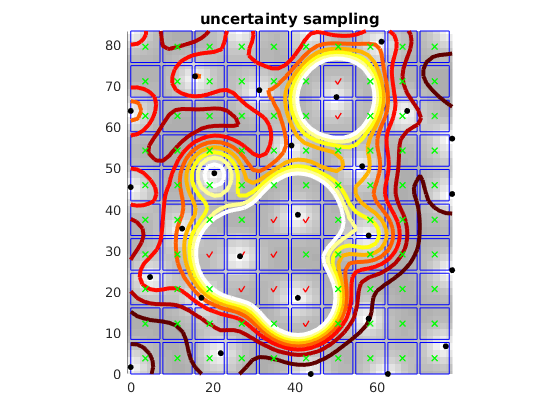

In [21]:
figure; clf;hold on;
[~, ~, f, fs2] = region_measure_unc.predict_points(x_gnd);
plot_demo(x_shape, x_gnd, f, fs2, unc.collected_locs, regions, level, region_measure_unc.alpha, region_measure_unc.beta2, found, 'plotTailGaussian', false);
set(gcf, 'Position', [000, 400, 280, 280]);axis equal;
title('uncertainty sampling');
drawnow;

## ei

In [22]:
ei = ExpectedImprovement(gp_model, gp_para, x_gnd);

In [23]:
for query_count = 0:queryLen-1
    u = ei.utility();
    if query_count==0 %for all algorithms to start from same point
        ind = ind_start;
    else
        [~, ind] = max_tiebreak(u);
    end
    ei.update(x_gnd(ind, :), y_gnd(ind, :));
end

In [24]:
region_measure_ei = ActiveAreaSearch(gp_model, gp_para, x_gnd, regions, level, side, highprob);
found = region_measure_ei.update(ei.collected_locs, ei.collected_vals);

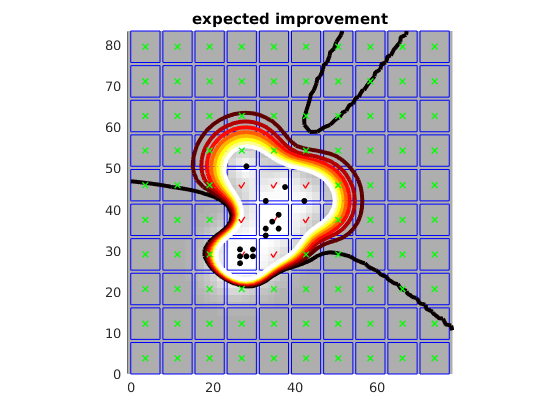

In [25]:
figure; clf;hold on;
[~, ~, f, fs2] = region_measure_ei.predict_points(x_gnd);
plot_demo(x_shape, x_gnd, f, fs2, ei.collected_locs, regions, level, region_measure_ei.alpha, region_measure_ei.beta2, found, 'plotTailGaussian', false);
set(gcf, 'Position', [300, 400, 280 , 280]);axis equal;
title('expected improvement');
drawnow;

## rnd

In [26]:
rnd = RandomSampling(gp_model, gp_para, x_gnd);

In [27]:
for query_count = 0:queryLen-1
    u = rnd.utility();
    if query_count==0 %for all algorithms to start from same point
        ind = ind_start;
    else
        [~, ind] = max_tiebreak(u);
    end
    rnd.update(x_gnd(ind, :), y_gnd(ind, :));
end

In [28]:
region_measure_rnd = ActiveAreaSearch(gp_model, gp_para, x_gnd, regions, level, side, highprob);
found = region_measure_rnd.update(rnd.collected_locs, rnd.collected_vals);

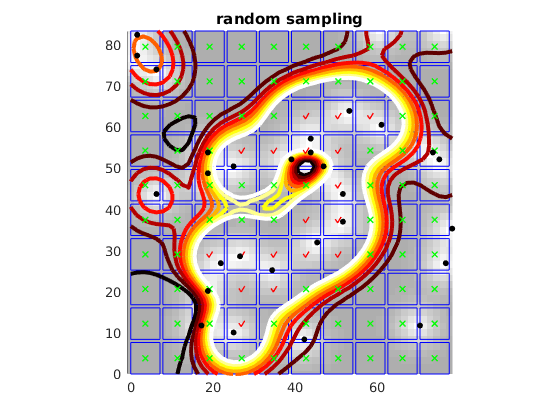

In [29]:
figure; clf;hold on;
[~, ~, f, fs2] = region_measure_rnd.predict_points(x_gnd);
plot_demo(x_shape, x_gnd, f, fs2, rnd.collected_locs, regions, level, region_measure_rnd.alpha, region_measure_rnd.beta2, found, 'plotTailGaussian', false);
% color_line3(x_gnd(:,1),x_gnd(:,2),ones(length(x_gnd(:,1)),1),f,'.')
% scatter(rnd.collected_locs(:,1), rnd.collected_locs(:,2), 20, 'mo', 'filled');
set(gcf, 'Position', [600, 400, 280, 280]);axis equal;
title('random sampling');
drawnow;